In [1]:
import os
import dnnlib
import torch
import numpy as np
import matplotlib.pyplot as plt
from solver_utils import get_schedule

In [4]:
# Utils for reading the AMED predictor
def read_amed_predictor(AMED_predictor, num_steps, sigma_min=0.0292, sigma_max=14.6146, device=None, schedule_type='polynomial', schedule_rho=7, net=None):
    t_steps = get_schedule(num_steps, sigma_min, sigma_max, device=device, schedule_type=schedule_type, schedule_rho=schedule_rho, net=net)
    schedule_type = AMED_predictor.schedule_type
    schedule_rho = AMED_predictor.schedule_rho
    ones = torch.tensor([1]).reshape(-1,)
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):
        r, scale_dir, scale_time = get_amed_prediction(AMED_predictor, t_cur, t_next, batch_size=1)
        t_mid = (t_next ** r) * (t_cur ** (1 - r))
        t_steps_amed = torch.cat((t_cur.reshape(-1,), t_mid.reshape(-1,), t_next.reshape(-1,))) if i == 0 else torch.cat((t_steps_amed, t_mid.reshape(-1,), t_next.reshape(-1,)))
        scale_dirs = torch.cat((ones, scale_dir.reshape(-1,), ones)) if i == 0 else torch.cat((scale_dirs, scale_dir.reshape(-1,), ones))
        scale_times = torch.cat((ones, scale_time.reshape(-1,), ones)) if i == 0 else torch.cat((scale_times, scale_time.reshape(-1,), ones))
    return t_steps_amed, scale_dirs, scale_times


def get_amed_prediction(AMED_predictor, t_cur, t_next, batch_size):
    unet_enc = torch.zeros((batch_size, 8, 8), device=t_cur.device)
    output = AMED_predictor(unet_enc, t_cur, t_next)
    output_list = [*output]
    if len(output_list) == 2:
        try:
            use_scale_time = AMED_predictor.module.scale_time
        except:
            use_scale_time = AMED_predictor.scale_time
        if use_scale_time:
            r, scale_time = output_list
            scale_dir = torch.ones_like(scale_time)
        else:
            r, scale_dir = output_list
            scale_time = torch.ones_like(scale_dir)
    elif len(output_list) == 3:
        r, scale_dir, scale_time = output_list
    else:
        r = output
        scale_dir = torch.ones_like(r)
        scale_time = torch.ones_like(r)
    return r, scale_dir, scale_time


def make_beta_schedule(schedule, n_timestep, linear_start=1e-4, linear_end=2e-2, cosine_s=8e-3):
    if schedule == "linear":
        betas = (torch.linspace(linear_start ** 0.5, linear_end ** 0.5, n_timestep, dtype=torch.float64) ** 2)
    elif schedule == "cosine":
        timesteps = (torch.arange(n_timestep + 1, dtype=torch.float64) / n_timestep + cosine_s)
        alphas = timesteps / (1 + cosine_s) * np.pi / 2
        alphas = torch.cos(alphas).pow(2)
        alphas = alphas / alphas[0]
        betas = 1 - alphas[1:] / alphas[:-1]
        betas = np.clip(betas, a_min=0, a_max=0.999)
    elif schedule == "sqrt_linear":
        betas = torch.linspace(linear_start, linear_end, n_timestep, dtype=torch.float64)
    elif schedule == "sqrt":
        betas = torch.linspace(linear_start, linear_end, n_timestep, dtype=torch.float64) ** 0.5
    else:
        raise ValueError(f"schedule '{schedule}' unknown.")
    return betas.numpy()


class SD_scheduler(torch.nn.Module):
    def __init__(self,
        alphas_cumprod,
        epsilon_t       = 1e-3,                 # Minimum t-value used during training.
        beta_d          = 9.0420,               # Extent of the noise level schedule.
        beta_min        = 0.8477,               # Initial slope of the noise level schedule.
    ):
        super().__init__()
        self.beta_d = beta_d
        self.beta_min = beta_min
        self.epsilon_t = epsilon_t
        
        log_alphas = 0.5 * torch.log(alphas_cumprod)
        self.M = len(log_alphas)
        self.t_array = torch.linspace(0., 1., self.M + 1)[1:].reshape((1, -1))
        self.log_alpha_array = log_alphas.reshape((1, -1,))

        self.sigma_min = float(self.sigma(epsilon_t))
        self.sigma_max = float(self.sigma(1))
        
    def marginal_log_mean_coeff(self, t):
        t = torch.tensor(t)
        return self.interpolate_fn(t.reshape((-1, 1)), self.t_array.to(t.device), self.log_alpha_array.to(t.device)).reshape((-1))

    def marginal_alpha(self, t):
        return torch.exp(self.marginal_log_mean_coeff(t))

    def marginal_std(self, t):
        return torch.sqrt(1. - torch.exp(2. * self.marginal_log_mean_coeff(t)))

    def sigma(self, t):
        return self.marginal_std(t) / self.marginal_alpha(t)

    def sigma_inv(self, sigma):
        lamb = -(sigma.log())
        log_alpha = -0.5 * torch.logaddexp(torch.zeros((1,)).to(lamb.device), -2. * lamb)
        t = self.interpolate_fn(log_alpha.reshape((-1, 1)), torch.flip(self.log_alpha_array.to(lamb.device), [1]), torch.flip(self.t_array.to(lamb.device), [1]))
        return t.reshape((-1,))
    
    def interpolate_fn(self, x, xp, yp):
        N, K = x.shape[0], xp.shape[1]
        all_x = torch.cat([x.unsqueeze(2), xp.unsqueeze(0).repeat((N, 1, 1))], dim=2)
        sorted_all_x, x_indices = torch.sort(all_x, dim=2)
        x_idx = torch.argmin(x_indices, dim=2)
        cand_start_idx = x_idx - 1
        start_idx = torch.where(
            torch.eq(x_idx, 0),
            torch.tensor(1, device=x.device),
            torch.where(
                torch.eq(x_idx, K), torch.tensor(K - 2, device=x.device), cand_start_idx,
            ),
        )
        end_idx = torch.where(torch.eq(start_idx, cand_start_idx), start_idx + 2, start_idx + 1)
        start_x = torch.gather(sorted_all_x, dim=2, index=start_idx.unsqueeze(2)).squeeze(2)
        end_x = torch.gather(sorted_all_x, dim=2, index=end_idx.unsqueeze(2)).squeeze(2)
        start_idx2 = torch.where(
            torch.eq(x_idx, 0),
            torch.tensor(0, device=x.device),
            torch.where(
                torch.eq(x_idx, K), torch.tensor(K - 2, device=x.device), cand_start_idx,
            ),
        )
        y_positions_expanded = yp.unsqueeze(0).expand(N, -1, -1)
        start_y = torch.gather(y_positions_expanded, dim=2, index=start_idx2.unsqueeze(2)).squeeze(2)
        end_y = torch.gather(y_positions_expanded, dim=2, index=(start_idx2 + 1).unsqueeze(2)).squeeze(2)
        cand = start_y + (x - start_x) * (end_y - start_y) / (end_x - start_x)
        return cand

In [17]:
# Construct AMED predictor

if not os.path.exists("./exp/00027-ms_coco-6-20-dpmpp-dpmpp-2-discrete"):
    raise ValueError("Download the AMED predictor (00027-ms_coco-6-20-dpmpp-dpmpp-2-discrete) and unzip to './exp'. \
                     from 'https://drive.google.com/drive/folders/1KlS0mV3qKMBu1qghy9sXRrjL2Aic4_fN'")
predictor_path = '27'
device = torch.device('cpu')
exp_path = './exp'

# Load AMED predictor
if not predictor_path.endswith('pt'):      # load by experiment number
    # find the directory with trained AMED predictor
    predictor_path_str = '0' * (5 - len(predictor_path)) + predictor_path
    for file_name in os.listdir(exp_path):
        if file_name.split('-')[0] == predictor_path_str:
            file_list = [f for f in os.listdir(os.path.join(exp_path, file_name)) if f.endswith("pt")]
            max_index = -1
            max_file = None
            for ckpt_name in file_list:
                file_index = int(ckpt_name.split("-")[-1].split(".")[0])
                if file_index > max_index:
                    max_index = file_index
                    max_file = ckpt_name
            predictor_path = os.path.join(exp_path, file_name, max_file)
            break
print(f'Loading AMED predictor from "{predictor_path}"...')
amed_dict = torch.load(predictor_path, map_location=torch.device('cpu'))['model']

AMED_kwargs = dnnlib.EasyDict()
AMED_kwargs.update(img_resolution=64)
AMED_kwargs.class_name = 'training.networks.AMED_predictor'
AMED_kwargs.update(num_steps=amed_dict.num_steps, sampler_stu=amed_dict.sampler_stu, sampler_tea=amed_dict.sampler_tea, \
                        M=amed_dict.M, guidance_type=amed_dict.guidance_type, guidance_rate=amed_dict.guidance_rate, \
                        schedule_rho=amed_dict.schedule_rho, schedule_type=amed_dict.schedule_type, afs=amed_dict.afs, \
                        dataset_name=amed_dict.dataset_name, scale_dir=amed_dict.scale_dir, scale_time=amed_dict.scale_time, \
                        max_order=amed_dict.max_order, predict_x0=amed_dict.predict_x0, lower_order_final=amed_dict.lower_order_final)
AMED_predictor = dnnlib.util.construct_class_by_name(**AMED_kwargs) # subclass of torch.nn.Module
AMED_predictor.load_state_dict(amed_dict.state_dict())

Loading AMED predictor from "./exp/00027-ms_coco-6-20-dpmpp-dpmpp-2-discrete/network-snapshot-000005.pt"...


<All keys matched successfully>

In [5]:
# Read AMED predictor
if AMED_predictor.dataset_name == 'ms_coco':
    betas = make_beta_schedule('linear', 1000, linear_start=0.00085, linear_end=0.0120, cosine_s=8e-3)
    alphas = 1. - betas
    alphas_cumprod = torch.tensor(np.cumprod(alphas, axis=0), device=device)
    scheduler = SD_scheduler(alphas_cumprod).to(device)
    sigma_min = 0.0292
    sigma_max = 14.6146
else:
    scheduler = None
    sigma_min = 0.002
    sigma_max = 80

t_steps_ori = get_schedule(2*AMED_predictor.num_steps-1, sigma_min, sigma_max, device=device, schedule_type=AMED_predictor.schedule_type, \
                           schedule_rho=AMED_predictor.schedule_rho, net=scheduler)
t_steps, scale_dirs, scale_times = read_amed_predictor(AMED_predictor, AMED_predictor.num_steps, sigma_min, sigma_max, device=device, schedule_type=AMED_predictor.schedule_type, \
                              schedule_rho=AMED_predictor.schedule_rho, net=scheduler)
t_steps_ori = [round(t.item()) for t in (1000 * scheduler.sigma_inv(t_steps_ori) - 1).data]
t_steps = [round(t.item()) for t in (1000 * scheduler.sigma_inv(t_steps) - 1).data]
scale_dirs = [round(t.item(), 4) for t in scale_dirs.data]
scale_times = [round(t.item(), 4) for t in scale_times.data]
print('Original   :', t_steps_ori)
print('AMED       :', t_steps)
print('Grad scale :', scale_dirs)
print('Time scale :', scale_times)

Original   : [999, 899, 799, 699, 599, 500, 400, 300, 200, 100, 0]
AMED       : [999, 885, 799, 705, 599, 492, 400, 329, 200, 73, 0]
Grad scale : [1.0, 0.9974, 1.0, 0.9904, 1.0, 0.991, 1.0, 0.9905, 1.0, 0.9904, 1.0]
Time scale : [1.0, 0.9872, 1.0, 1.0152, 1.0, 1.0186, 1.0, 0.9934, 1.0, 0.9731, 1.0]


/var/folders/6_/ps_h4zmj3rs2s2rqr1whb3zh0000gn/T/ipykernel_46814/1004945328.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


In [6]:
# Loading Stable Diffusion models
from diffusers import StableDiffusionPipeline

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda")

/opt/anaconda3/envs/diff/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [30]:
# Construct Scheduler and Generate Images
from diffusers_amed_plugin_dpmpp import DPMSolverMultistepScheduler

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.scheduler.scale_dirs = scale_dirs
pipe.scheduler.scale_times = scale_times

prompt = "a photogragh of an astronaut riding a horse"
seed = 10
num_steps = 10
sampling_schedule_amed = t_steps
sampling_schedule_ays  = [999, 850, 736, 645, 545, 455, 343, 233, 124, 24, 0]   # https://research.nvidia.com/labs/toronto-ai/AlignYourSteps/

# Default schedule
torch.manual_seed(seed)
default_images = pipe(
    prompt, num_images_per_prompt=1,
    num_inference_steps=num_steps,
).images

# AYS schedule
torch.manual_seed(seed)
ays_images = pipe(
    prompt, num_images_per_prompt=1,
    timesteps=sampling_schedule_ays,
).images

# AMED schedule
torch.manual_seed(seed)
amed_images = pipe(
    prompt, num_images_per_prompt=1,
    num_inference_steps=num_steps,
    timesteps=sampling_schedule_amed,
).images

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

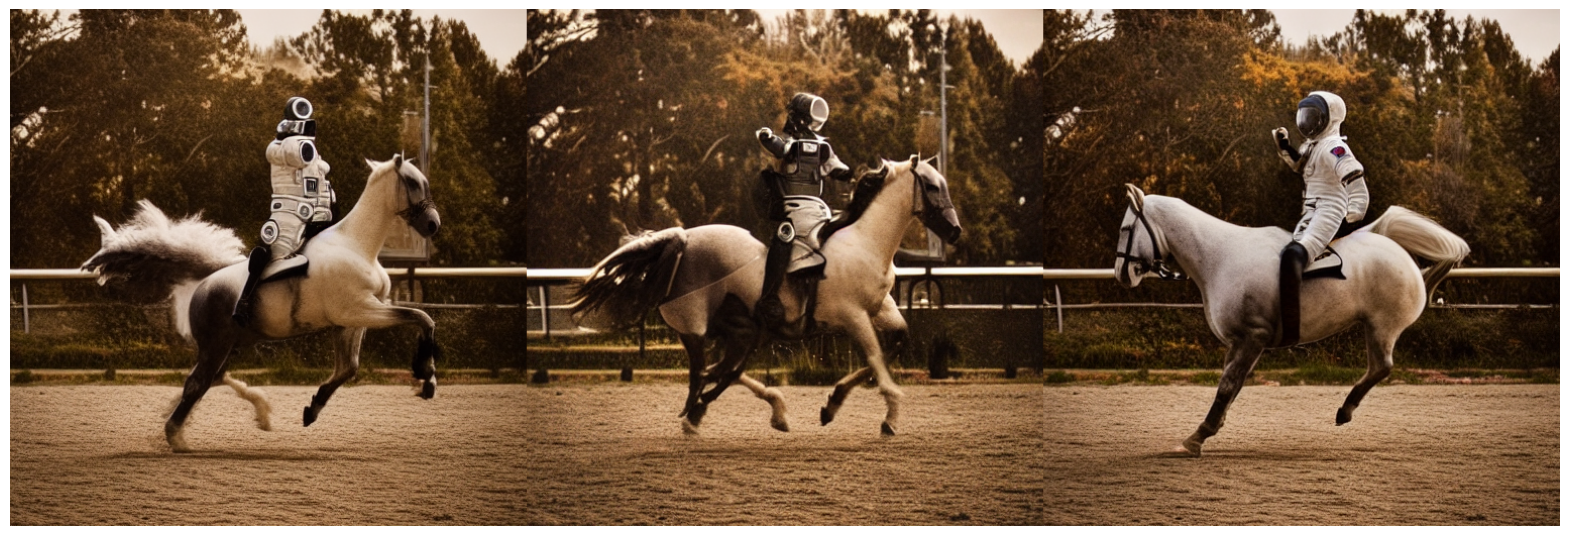

In [31]:
# Show images
image_grid = np.concatenate((default_images[0], ays_images[0], amed_images[0]), axis=1)
plt.figure(figsize=(20, 10))
plt.imshow(image_grid)
plt.axis('off')
plt.show()